In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/TDAC_seq/tdac_seq")
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [2]:
fastq_files = {
    "ddda_data_1": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR309/HJR309_rep1_1/HJR309_rep1_1.fastq.gz",
    "ddda_data_2": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR309/HJR309_rep1_2/HJR309_rep1_2.fastq.gz",
    "ddda_data_3": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR309/HJR309_rep1_3/HJR309_rep1_3.fastq.gz",
    "ddda_data_235": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR309/HJR309_235/HJR309_235.fastq.gz"
}

# Reference region dictionary (same for all)
ref_range_dict = {
    'HJR235': ('chr7', 27158522, 27163197)
}

# Directories and genome file
working_base_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR309/"
genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna"
bias_model_path = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl"

# Create plot directory
plot_dir = os.path.join(working_base_dir, "plot")
os.system("mkdir -p " + plot_dir)

# Dictionary to hold all ddda_data objects
ddda_data_dict = {}

# Iterate over each FASTQ and process
for var_name, fastq_path in fastq_files.items():
    ddda_data = ddda_dataset(
        ID=var_name,
        region_dict=ref_range_dict,
        genome_file=genome_file,
        fastq_file=fastq_path,
        working_dir=working_base_dir
    )

    # Load DddA bias model
    with open(bias_model_path, "rb") as f:
        ddda_data.bias_model = pickle.load(f)

    # Align reads
    ddda_data.align_reads(
        start_gap_threshold=500,
        end_gap_threshold=500
    )

    # Store in dictionary under the correct variable name
    ddda_data_dict[var_name] = ddda_data

Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|██████████| 91374/91374 [01:43<00:00, 880.56it/s] 


65061 reads aligned. 26313 reads unaligned
Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|██████████| 128439/128439 [02:29<00:00, 857.15it/s]


95593 reads aligned. 32846 reads unaligned
Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|██████████| 157898/157898 [03:03<00:00, 862.70it/s] 


109991 reads aligned. 47907 reads unaligned
Loading reference genome
Extracting sequences for each locus
Computing sequence bias


100%|██████████| 246329/246329 [04:50<00:00, 846.59it/s] 


189963 reads aligned. 56366 reads unaligned


In [40]:
# Inputs
locus = "HJR235"

# Sample IDs and motif positions
sample_ids = ["ddda_data_1", "ddda_data_2", "ddda_data_3", "ddda_data_235"]
motif_positions = {
    "ddda_data_1": (2613, 2635),
    "ddda_data_2": (2612, 2634),
    "ddda_data_3": (2605, 2647),
    "ddda_data_235": (2623, 2645)
}

# Store results
all_edits_del_full = {}
all_edits_undel_full = {}
all_track_deleted = {}
all_track_undeleted = {}

for sample_id in sample_ids:
    ddda_data = ddda_data_dict[sample_id]  # Access from dictionary
    motif_start, motif_end = motif_positions[sample_id]

    del_matrix = ddda_data.del_dict[locus]
    motif_del = np.array(np.max(del_matrix[:, motif_start:motif_end], axis=1).todense())[:, 0]
    del_read_inds = np.where(motif_del == 1)[0]

    upstream_del = np.array(np.max(del_matrix[:, :motif_start], axis=1).todense())[:, 0]
    downstream_del = np.array(np.max(del_matrix[:, motif_end:], axis=1).todense())[:, 0]
    valid_filter = np.where((upstream_del == 0) & (downstream_del == 0))[0]
    del_read_inds = np.intersect1d(del_read_inds, valid_filter)

    undel_read_inds = np.where(np.array(np.max(del_matrix, axis=1).todense())[:, 0] == 0)[0]

    min_num = min(len(del_read_inds), len(undel_read_inds), 10000)
    del_read_inds = np.random.choice(del_read_inds, min_num, replace=False)
    undel_read_inds = np.random.choice(undel_read_inds, min_num, replace=False)

    del_read_ids = ddda_data.dedup_reads(locus, np.array(ddda_data.read_ids[locus])[del_read_inds])
    undel_read_ids = ddda_data.dedup_reads(locus, np.array(ddda_data.read_ids[locus])[undel_read_inds])
    del_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in del_read_ids])
    undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

    selected_read_inds = np.concatenate([del_read_inds, undel_read_inds])
    selected_del_flags = np.concatenate([np.ones(len(del_read_inds)), np.zeros(len(undel_read_inds))])
    edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())
    read_edit_num = np.sum(edits, axis=1)

    del_filter = np.where(selected_del_flags == 1)[0]
    row_order_del = [i for i in np.argsort(-read_edit_num) if i in del_filter]
    edits_del = edits[row_order_del, :]

    undel_filter = np.where(selected_del_flags == 0)[0]
    row_order_undel = [i for i in np.argsort(-read_edit_num) if i in undel_filter]
    edits_undel = edits[row_order_undel, :]

    all_edits_del_full[sample_id] = edits_del
    all_edits_undel_full[sample_id] = edits_undel
    
    track_deleted = np.mean(edits[np.array(selected_del_flags) == 1, :], axis=0)
    track_undeleted = np.mean(edits[np.array(selected_del_flags) == 0, :], axis=0)

    # Smooth with convolution
    track_deleted = np.convolve(track_deleted, np.ones(50) / 50, mode='same')
    track_undeleted = np.convolve(track_undeleted, np.ones(50) / 50, mode='same')

    # Apply plot range trimming
    track_deleted = track_deleted[plot_range]
    track_undeleted = track_undeleted[plot_range]

    # Save tracks
    all_track_deleted[sample_id] = track_deleted
    all_track_undeleted[sample_id] = track_undeleted
    

100%|██████████| 10000/10000 [00:01<00:00, 6600.96it/s]
10000it [00:00, 1169372.14it/s]
100%|██████████| 10000/10000 [00:01<00:00, 6594.22it/s]
10000it [00:00, 1201324.40it/s]
100%|██████████| 10000/10000 [00:01<00:00, 6628.55it/s]
10000it [00:00, 1119675.39it/s]
100%|██████████| 10000/10000 [00:01<00:00, 6660.19it/s]
10000it [00:00, 1097123.72it/s]
100%|██████████| 2610/2610 [00:00<00:00, 6593.67it/s]
2610it [00:00, 1259739.18it/s]
100%|██████████| 2610/2610 [00:00<00:00, 6572.92it/s]
2610it [00:00, 1323556.21it/s]
100%|██████████| 794/794 [00:00<00:00, 6562.90it/s]
794it [00:00, 1240326.77it/s]
100%|██████████| 794/794 [00:00<00:00, 6593.94it/s]
794it [00:00, 1071517.82it/s]


In [42]:
# Now just adjust this to change the analysis range
plot_range = np.arange(2510, 2710)

# Recompute means
all_del_means = {sid: np.mean(all_edits_del_full[sid][:, plot_range], axis=1) for sid in sample_ids}
all_undel_means = {sid: np.mean(all_edits_undel_full[sid][:, plot_range], axis=1) for sid in sample_ids}


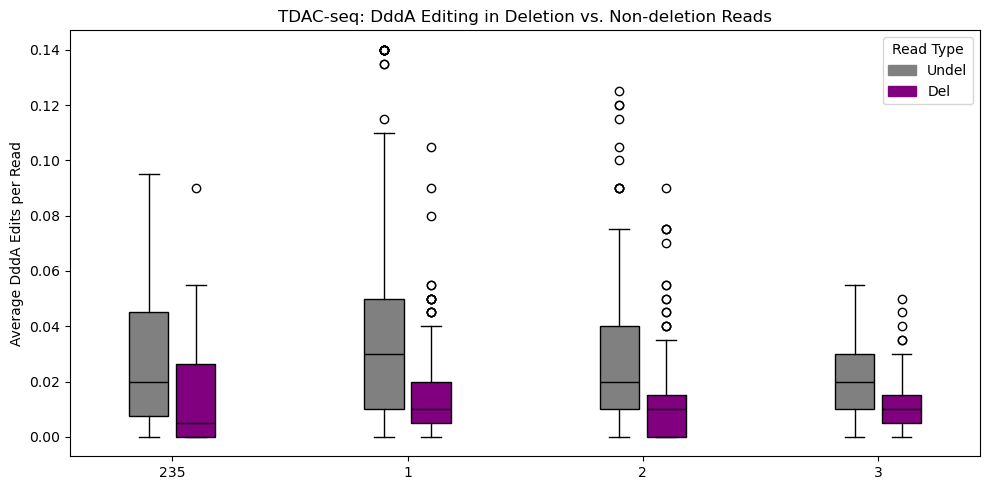

In [43]:
# Define sample order and colors
sample_ids = ["ddda_data_235", "ddda_data_1", "ddda_data_2", "ddda_data_3"]
colors = ['grey', 'purple']  # Undel, Del

# Prepare box plot data
box_data = []
box_colors = []
positions = []
labels = []

spacing = 1.5  # spacing between different samples
offset = 0.3   # small offset between Undel and Del in each sample

for i, sample_id in enumerate(sample_ids):
    sample_label = sample_id.split('_')[-1]
    x_base = i * spacing

    # Undel
    box_data.append(all_undel_means[sample_id])
    box_colors.append(colors[0])
    positions.append(x_base)
    labels.append(sample_label)

    # Del
    box_data.append(all_del_means[sample_id])
    box_colors.append(colors[1])
    positions.append(x_base + offset)

# Create box plot
plt.figure(figsize=(10, 5))
box = plt.boxplot(box_data, positions=positions, widths=0.25, patch_artist=True)

# Color the boxes
for patch, color in zip(box['boxes'], box_colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')

# Style medians
for median in box['medians']:
    median.set_color('black')

# Set x-tick labels at the midpoint of each sample group
xtick_positions = [p + offset / 2 for p in positions[::2]]
plt.xticks(xtick_positions, labels)

plt.ylabel("Average DddA Edits per Read")
plt.title("TDAC-seq: DddA Editing in Deletion vs. Non-deletion Reads")

# Add legend
plt.legend(
    handles=[plt.Rectangle((0, 0), 1, 1, color=colors[0]),
             plt.Rectangle((0, 0), 1, 1, color=colors[1])],
    labels=['Undel', 'Del'],
    title='Read Type',
    loc='upper right'
)

plt.tight_layout()

# Uncomment to save
#plt.savefig(os.path.join(plot_dir, "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR309/HJR309_singleguide_boxplot_sum.pdf"))

plt.show()


In [45]:
#CTCF
CTCF_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
CTCF_values = np.zeros_like(CTCF_x_values)
CTCF_values[(CTCF_x_values >= 27161134) & (CTCF_x_values < 27161153)] = 3  # Adjust indices as needed
CTCF_values_region=CTCF_values[plot_range]
CTCF_x_values_region=CTCF_x_values[plot_range]

In [46]:
#YY1
YY1_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
YY1_values = np.zeros_like(CTCF_x_values)
YY1_values[(YY1_x_values >= 27161148) & (YY1_x_values < 27161161)] = 3  # Adjust indices as needed
YY1_values_region=YY1_values[plot_range]
YY1_x_values_region=YY1_x_values[plot_range]

In [47]:
#HOXA-sgRNA-2
data_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
bar_values = np.zeros_like(data_x_values)
bar_values[(data_x_values >= 27161141) & (data_x_values < 27161161)] = 3  # Adjust indices as needed
bar_values_region=bar_values[plot_range]
data_x_values_region=data_x_values[plot_range]

In [48]:
#HOXA-sgRNA-3
data_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
bar_values_2 = np.zeros_like(data_x_values)
bar_values_2[(data_x_values >= 27161126) & (data_x_values < 27161146)] = 3  # Adjust indices as needed
bar_values_region_2=bar_values_2[plot_range]
data_x_values_region=data_x_values[plot_range]

In [49]:
#HOXA-sgRNA-4
data_x_values = np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)
bar_values_3 = np.zeros_like(data_x_values)
bar_values_3[(data_x_values >= 27161133) & (data_x_values < 27161153)] = 3  # Adjust indices as needed
bar_values_region_3=bar_values_3[plot_range]
data_x_values_region=data_x_values[plot_range]

In [50]:
ATAC = '/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR235_050624/molm13/SRR7010323_rmdups.bedgraph'
bedgraph_data = pd.read_csv(ATAC, sep='\t', header=None, names=['chrom', 'start', 'end', 'value'])

# chr21이고 start가 38118238에서 38127665 사이인 데이터 필터링
filtered_data = bedgraph_data[(bedgraph_data['chrom'] == ref_range_dict[locus][0]) &
                              (bedgraph_data['start'] >= ref_range_dict[locus][1]) &
                              (bedgraph_data['start'] <= ref_range_dict[locus][2])]

# x값과 y값 설정
all_positions = pd.DataFrame({'start': np.arange(ref_range_dict[locus][1], ref_range_dict[locus][2]+1)})

# Merging with the filtered data, filling missing values with zero
merged_data = pd.merge(all_positions, filtered_data, on='start', how='left').fillna(0)

ATAC_x_values = merged_data['start']
ATAC_y_values = merged_data['value'].values



In [51]:
ATAC_x_values_plot = ATAC_x_values[1500:3500]
ATAC_y_values_plot = ATAC_y_values[1500:3500]
ATAC_y_values_convolve_plot=np.convolve(ATAC_y_values_plot, np.ones(50), 'same')/50

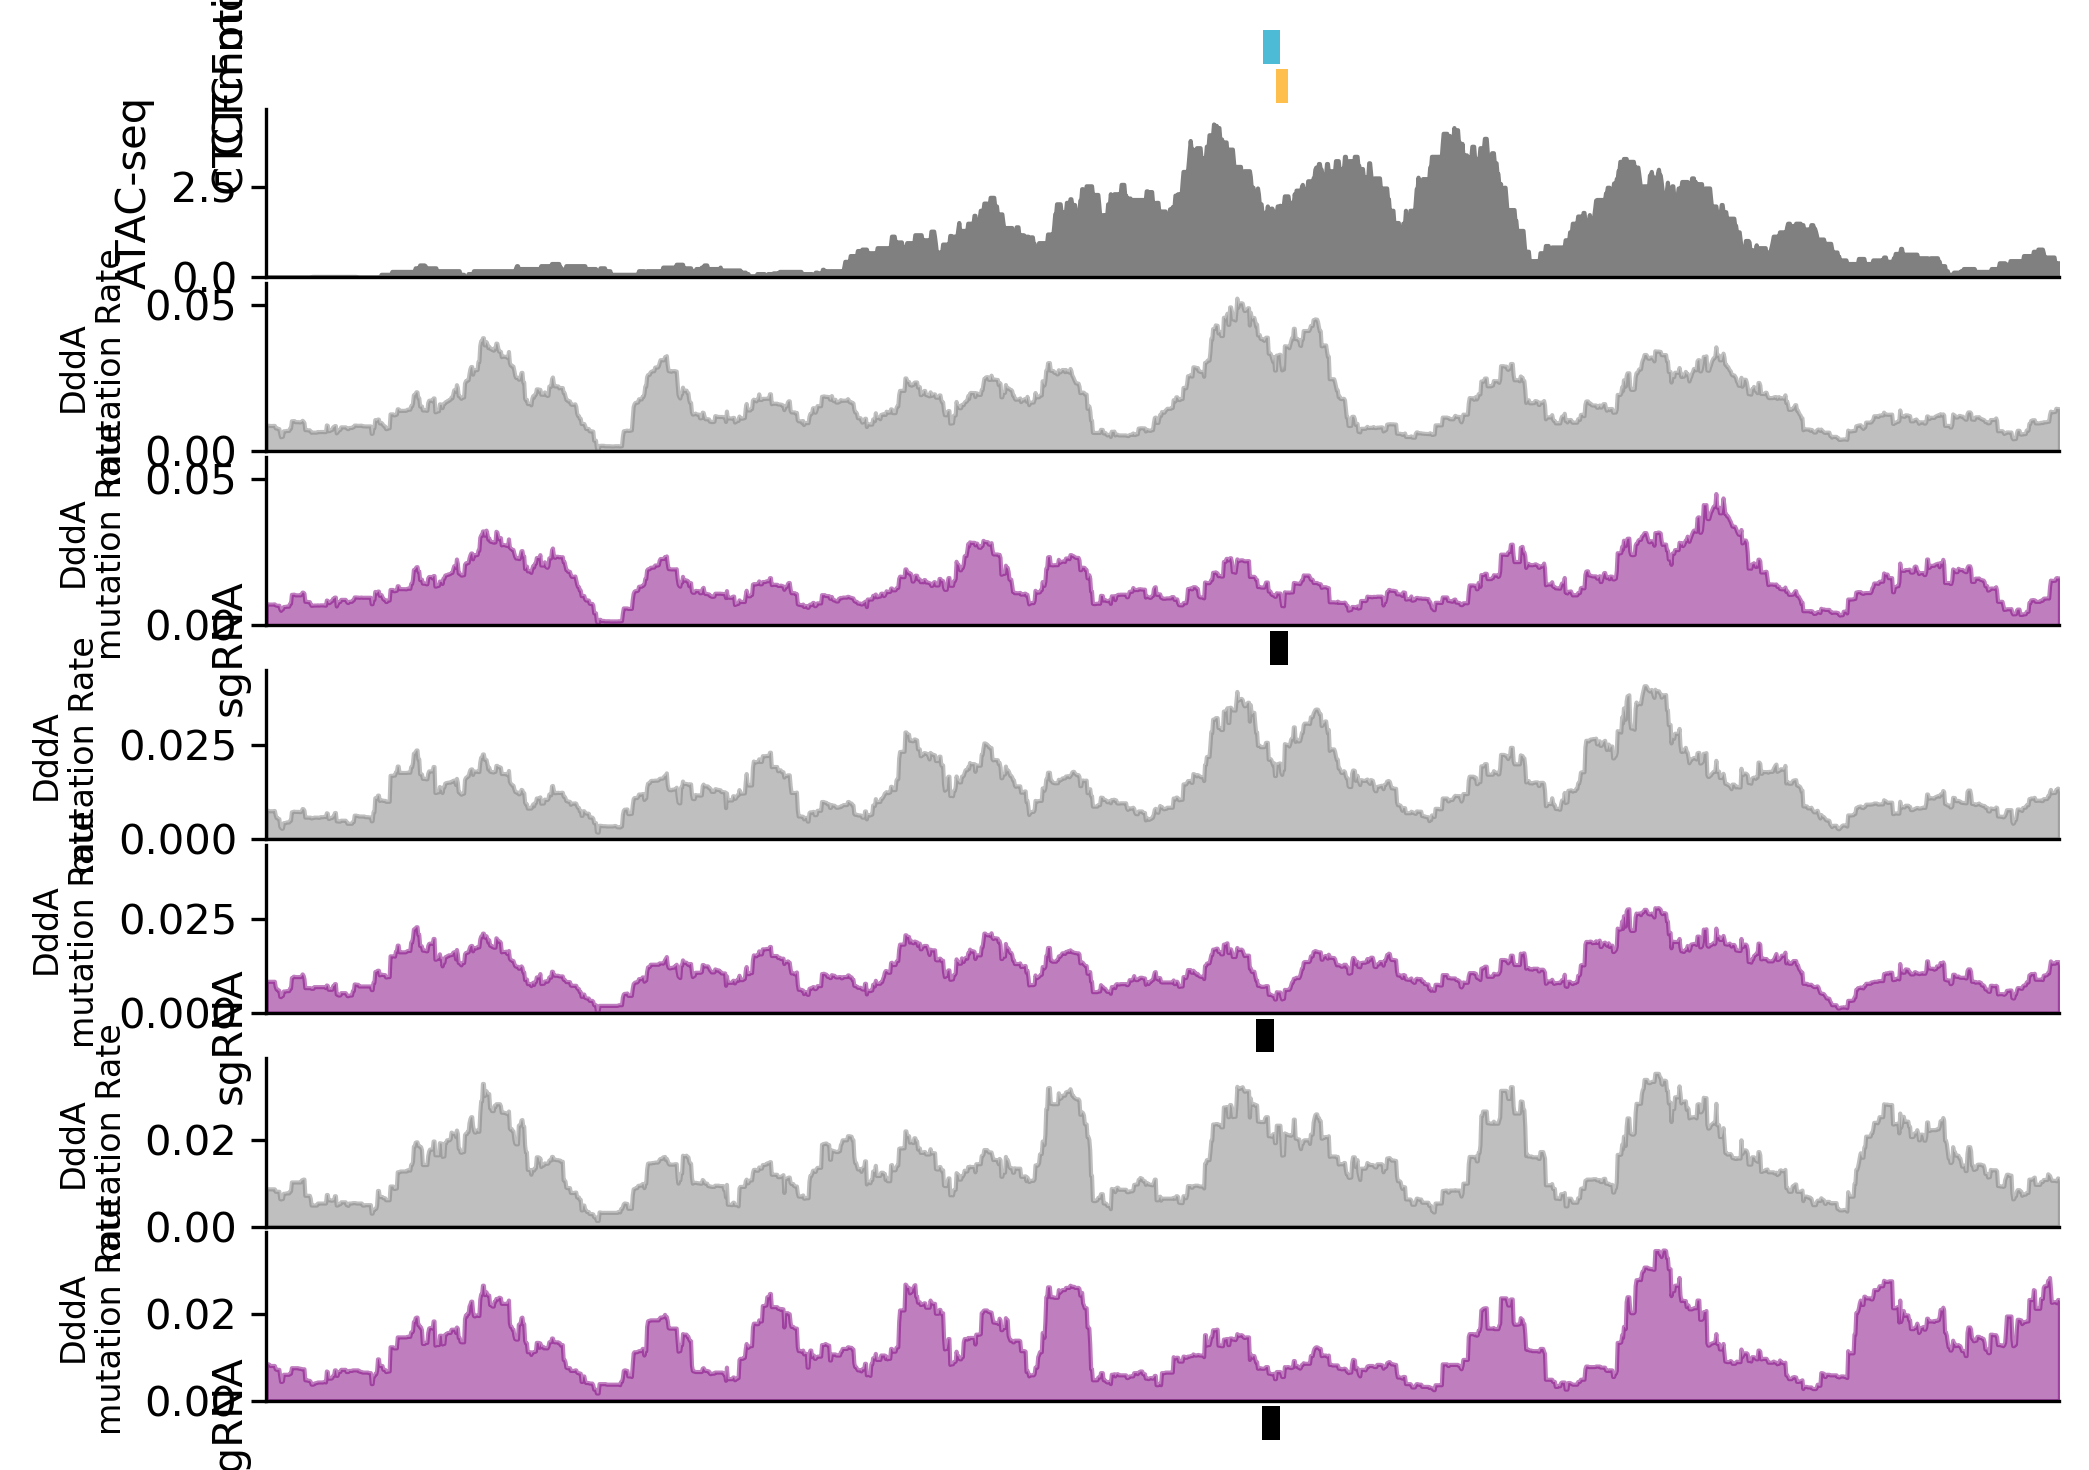

In [56]:
plot_range = np.arange(1500, 3500)
fig = plt.figure(dpi=300,figsize=(8, 5))
gs = GridSpec(12, 2, width_ratios=[20, 0.5], height_ratios=[0.1,0.1,0.5,0.5,0.5,0.1,0.5,0.5,0.1,0.5,0.5,0.1])
# CTCF motif
ax0 = fig.add_subplot(gs[0, 0])
ax0.bar(CTCF_x_values_region, CTCF_values_region, color='#4dbbd5', alpha=1, width=1.0)
ax0.set_xlim([CTCF_x_values_region.min(), CTCF_x_values_region.max()])
ax0.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax0.set_xticks([])  # Remove x-axis ticks for the bar plot
ax0.set_yticks([])  # Remove y-axis ticks for the bar plot
ax0.set_ylabel('CTCFmotif')
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['bottom'].set_visible(False)
ax0.spines['left'].set_visible(False)

# YY1 motif
ax1 = fig.add_subplot(gs[1, 0])
ax1.bar(YY1_x_values_region, YY1_values_region, color='orange', alpha=0.7, width=1.0)
ax1.set_xlim([YY1_x_values_region.min(), YY1_x_values_region.max()])
ax1.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax1.set_xticks([])  # Remove x-axis ticks for the bar plot
ax1.set_yticks([])  # Remove y-axis ticks for the bar plot
ax1.set_ylabel('CTCFmotif')
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# ATAC
ax2 = plt.subplot(gs[2,0])
ax2.fill_between(ATAC_x_values_plot, ATAC_y_values_convolve_plot, color='Grey', alpha=1)
ax2.set_xlim([ATAC_x_values_plot.min(), ATAC_x_values_plot.max()])
ax2.set_ylim([0, max(ATAC_y_values_convolve_plot) * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('ATAC-seq')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# HOXA-sgRNA-2_undeleted
ax3 = plt.subplot(gs[3,0])
x_values = np.arange(len(all_track_undeleted["ddda_data_1"]))
ax3.fill_between(x_values, all_track_undeleted["ddda_data_1"], color='grey', alpha=0.5)
ax3.set_xlim([x_values.min(), x_values.max()])
ax3.set_ylim([0, max(all_track_undeleted["ddda_data_1"]) * 1.1])
ax3.set_xticks([])  # Remove x-axis ticks
ax3.set_xlabel('')
ax3.set_ylabel('DddA\nmutation Rate', fontsize=8)

ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# HOXA-sgRNA-2_deleted
ax4 = plt.subplot(gs[4,0])
x_values = np.arange(len(all_track_deleted["ddda_data_1"]))
ax4.fill_between(x_values, all_track_deleted["ddda_data_1"], color='purple', alpha=0.5)
ax4.set_xlim([x_values.min(), x_values.max()])
ax4.set_ylim([0, max(all_track_undeleted["ddda_data_1"]) * 1.1])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('DddA\nmutation Rate', fontsize=8)

ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# HOXA-sgRNA-2
ax5 = fig.add_subplot(gs[5, 0])
ax5.bar(data_x_values_region, bar_values_region, color='black', alpha=1, width=1.0)
ax5.set_xlim([data_x_values_region.min(), data_x_values_region.max()])
ax5.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax5.set_xticks([])  # Remove x-axis ticks for the bar plot
ax5.set_yticks([])  # Remove y-axis ticks for the bar plot
ax5.set_ylabel('sgRNA')
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
ax5.spines['bottom'].set_visible(False)
ax5.spines['left'].set_visible(False)

# HOXA-sgRNA-3_undeleted
ax6 = plt.subplot(gs[6,0])
x_values = np.arange(len(all_track_undeleted["ddda_data_2"]))
ax6.fill_between(x_values, all_track_undeleted["ddda_data_2"], color='grey', alpha=0.5)
ax6.set_xlim([x_values.min(), x_values.max()])
ax6.set_ylim([0, max(all_track_undeleted["ddda_data_2"]) * 1.1])
ax6.set_xticks([])  # Remove x-axis ticks
ax6.set_xlabel('')
ax6.set_ylabel('DddA\nmutation Rate', fontsize=8)

ax6.spines['top'].set_visible(False)
ax6.spines['right'].set_visible(False)

# HOXA-sgRNA-3_deleted
ax7 = plt.subplot(gs[7,0])
x_values = np.arange(len(all_track_deleted["ddda_data_2"]))
ax7.fill_between(x_values, all_track_deleted["ddda_data_2"], color='purple', alpha=0.5)
ax7.set_xlim([x_values.min(), x_values.max()])
ax7.set_ylim([0, max(all_track_undeleted["ddda_data_2"]) * 1.1])
ax7.set_xticks([])  # Remove x-axis ticks
ax7.set_xlabel('')
ax7.set_ylabel('DddA\nmutation Rate', fontsize=8)

ax7.spines['top'].set_visible(False)
ax7.spines['right'].set_visible(False)

# HOXA-sgRNA-3
ax8 = fig.add_subplot(gs[8, 0])
ax8.bar(data_x_values_region, bar_values_region_2, color='black', alpha=1, width=1.0)
ax8.set_xlim([data_x_values_region.min(), data_x_values_region.max()])
ax8.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax8.set_xticks([])  # Remove x-axis ticks for the bar plot
ax8.set_yticks([])  # Remove y-axis ticks for the bar plot
ax8.set_ylabel('sgRNA')
ax8.spines['top'].set_visible(False)
ax8.spines['right'].set_visible(False)
ax8.spines['bottom'].set_visible(False)
ax8.spines['left'].set_visible(False)

# HOXA-sgRNA-4_undeleted
ax9 = plt.subplot(gs[9,0])
x_values = np.arange(len(all_track_undeleted["ddda_data_3"]))
ax9.fill_between(x_values, all_track_undeleted["ddda_data_3"], color='grey', alpha=0.5)
ax9.set_xlim([x_values.min(), x_values.max()])
ax9.set_ylim([0, max(all_track_undeleted["ddda_data_3"]) * 1.1])
ax9.set_xticks([])  # Remove x-axis ticks
ax9.set_xlabel('')
ax9.set_ylabel('DddA\nmutation Rate', fontsize=8)

ax9.spines['top'].set_visible(False)
ax9.spines['right'].set_visible(False)

# HOXA-sgRNA-4_deleted
ax10 = plt.subplot(gs[10,0])
x_values = np.arange(len(all_track_deleted["ddda_data_3"]))
ax10.fill_between(x_values, all_track_deleted["ddda_data_3"], color='purple', alpha=0.5)
ax10.set_xlim([x_values.min(), x_values.max()])
ax10.set_ylim([0, max(all_track_undeleted["ddda_data_3"]) * 1.1])
ax10.set_xticks([])  # Remove x-axis ticks
ax10.set_xlabel('')
ax10.set_ylabel('DddA\nmutation Rate', fontsize=8)

ax10.spines['top'].set_visible(False)
ax10.spines['right'].set_visible(False)

# HOXA-sgRNA-4
ax11 = fig.add_subplot(gs[11, 0])
ax11.bar(data_x_values_region, bar_values_region_3, color='black', alpha=1, width=1.0)
ax11.set_xlim([data_x_values_region.min(), data_x_values_region.max()])
ax11.set_ylim([0, 3])  # Set y-axis limits for the bar plot
ax11.set_xticks([])  # Remove x-axis ticks for the bar plot
ax11.set_yticks([])  # Remove y-axis ticks for the bar plot
ax11.set_ylabel('sgRNA')
ax11.spines['top'].set_visible(False)
ax11.spines['right'].set_visible(False)
ax11.spines['bottom'].set_visible(False)
ax11.spines['left'].set_visible(False)

plt.tight_layout()
plt.subplots_adjust(hspace=0.05, right=0.9) 
# Save the combined figure
#plt.savefig(os.path.join(plot_dir, "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR309/HJR309_1_accessibility_sum.pdf"))
plt.show()